# Ensemble Docking Results per protein conformation

Exploratory Data Analysis of the Ensemble docking results.
This notebook does the following:
- Jitter boxplots showing the single-conformation performance per library or per combination of libraries.
- Pair plot correlations between conformation properties.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../..')
from helper_modules.plotting_metrics import PlotMetric 
from helper_modules.run_or_load import run_or_load

## Load the available data
- This dataframe have been computed in previous notebooks.

### Protein metadata

In [2]:
prot_name = 'egfr'
DIR = '../1_Download_and_prepare_protein_ensembles'
path_to_file = f'{DIR}/TABLA_MTDATA_EGFR_175_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)

#### Include pocket volume information

In [3]:
DIR = '../3_Protein_Ensembles_Analysis/'
path_to_file = f'{DIR}/POVME3_results/Pocket_alignment/res_output.txt'
# Read the pocket volume results
df_pocket = pd.read_csv(path_to_file,
                        sep = '|', 
                        skiprows = 390, 
                        header = None, 
                        skipfooter = 3, 
                        engine = 'python',
                        names = ['pdb_id', 'volumen', 'surf_area'], 
                        index_col = 0)

# Include it to the main dataframe
df_pocket.index = df_prot.index
df_pocket = df_prot.merge(df_pocket, 
                          how='inner', 
                          left_index=True, 
                          right_index=True)

df_pocket.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,volumen,surf_area
1m14,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.6,1.000,23.058,2,"[695, 236]","[[1, 695], [975, 1210]]",0,[],None,NaN,1100.0,759.0
1m17,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.6,1.000,23.058,2,"[695, 236]","[[1, 695], [975, 1210]]",1,[AQ4],AQ4,370.253100,1189.0,799.0
1xkk,a unique structure for epidermal growth factor...,2004-12-07,1,A,2.4,0.936,19.256,5,"[701, 4, 4, 8, 260]","[[1, 701], [734, 737], [750, 753], [867, 874],...",2,"[FMM, PO4]",FMM,554.851103,922.0,924.0


## Compute some extra properties

- It is an *apo* or an *holo* conformation?

In [4]:
df_pocket.Entities = pd.to_numeric(df_pocket.Entities, errors = 'coerce')
df_pocket['Entities'].fillna(1, inplace = True)
df_pocket['Apo'] = ['holo' if i > 0 else 'apo' for i in df_pocket.NumLigs] 

# How many of each are there?
print('Number of Apo and Holo conformations:')
df_pocket['Apo'].value_counts()

Number of Apo and Holo conformations:


holo    158
apo      17
Name: Apo, dtype: int64

- Is the protein bound to other proteic entities?

In [5]:
df_pocket['Single Entity'] = ['bound' if int(i) > 1 else 'single' 
                              for i in df_pocket.Entities] 
# How many of each are there?
print('Number of `single` and `bound` crystalized conformations:')
df_pocket['Single Entity'].value_counts()

Number of `single` and `bound` crystalized conformations:


single    175
Name: Single Entity, dtype: int64

- Be sure that entries with no cocrystalized molecules have a `0` in their `Inhib_mass` column.

In [6]:
# Fill Na values inside Inhib_mass column with 0's
df_pocket['Inhib_mass'] = pd.to_numeric(
                                df_pocket['Inhib_mass']).fillna(0)

### Loading docking results

In [7]:
file_name = './df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X_dksc = df_dk_res.drop('activity', axis = 1)
X = X_dksc
# Extract the response variable: Activity
y = df_dk_res['activity']

#### Ratio of actives

In [8]:
# Proportion of active molecules R_2
R_a = round(y.sum() / len(y), 4)
R_a

0.0377

### Visualize the Docking performance per library

In [9]:
metric_name = 'roc_auc'
metric_kwargs = {'metric_name': metric_name}
libraries = ['DUD', 'DEKOIS', 'DUD_DEKOIS', 'DUD_DEKOIS_COCRYS']

raw_performances = []
for lib in libraries:
    df_perfs = PlotMetric(y_true = y.loc[lib.split('_')], 
               df_predictions = X.loc[lib.split('_')], 
               decreasing = True,
              ).format_metric_results(**metric_kwargs)
    raw_performances.append(df_perfs)

raw_performances_per_conf = pd.concat(
                                raw_performances, 
                                keys = [lib.replace('_', '\n')
                                        for lib in libraries], 
                                axis = 1)\
                        .droplevel(1, axis = 1)

Top ROC_AUC values
DUD                    0.819
DEKOIS                 0.738
DUD\nDEKOIS            0.808
DUD\nDEKOIS\nCOCRYS    0.819
dtype: float64


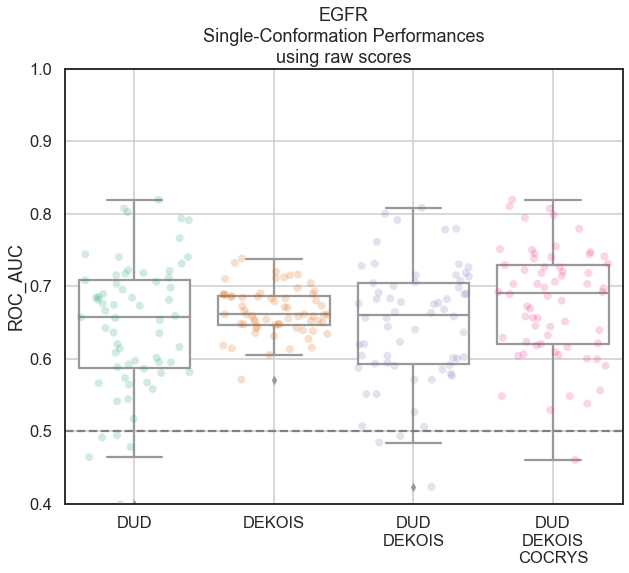

In [10]:
fig = plt.figure(figsize = (10,8))
ax = sns.stripplot(data = raw_performances_per_conf, 
                   jitter = 0.4, alpha = 0.2, size = 8)
sns.boxplot(data = raw_performances_per_conf, color = '#FFFFFFFF')
ax.set(ylim = (0.4,1), 
       title = f'{prot_name.upper()}' + 
       '\nSingle-Conformation Performances\nusing raw scores',
       ylabel = f'{metric_name.upper()}')
plt.axhline(0.5, label = 'Random', color = 'gray', ls = '--')
ax.grid()
print(f'Top {metric_name.upper()} values')
print(raw_performances_per_conf.max(axis = 0))

#### Get the individual performances (single-conformation performances)
- AUC-ROC
- Normalized Enrichment Factor

In [11]:
# AUC ROC
metric_params = {'metric_name': 'roc_auc'}
roc_auc = PlotMetric(y, X_dksc,
                        decreasing=True)\
                    .format_metric_results(rounded=5, 
                                           **metric_params)

# Normalized Enrichment Factor (Ra)
metric_params = {'metric_name': 'ef', 
                 'fraction': R_a, 
                 'method':'normalized'}
nef_Ra = PlotMetric(y, X_dksc,
                        decreasing=True)\
                    .format_metric_results(
                        rounded=5, 
                        **metric_params)

# Merge all dataframes
df_merged = df_pocket.join([roc_auc, nef_Ra], how='inner')
df_merged.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,volumen,surf_area,Apo,Single Entity,ROC AUC,EF
1xkk,a unique structure for epidermal growth factor...,2004-12-07,1.0,A,2.40,0.936,19.256,5,"[701, 4, 4, 8, 260]","[[1, 701], [734, 737], [750, 753], [867, 874],...",2,"[FMM, PO4]",FMM,554.851103,922.0,924.0,holo,single,0.55588,0.06667
2ito,structures of lung cancer-derived egfr mutants...,2007-04-03,1.0,A,3.25,0.965,20.331,3,"[695, 9, 260]","[[1, 695], [867, 875], [951, 1210]]",1,[IRE],IRE,422.711803,1021.0,724.0,holo,single,0.79399,0.19316
2itq,structures of lung cancer-derived egfr mutants...,2007-04-03,1.0,A,2.68,1.000,20.992,2,"[696, 260]","[[1, 696], [951, 1210]]",1,[ITQ],ITQ,440.324600,1133.0,701.0,holo,single,0.71776,0.16239
2itt,structures of lung cancer-derived egfr mutants...,2007-04-03,1.0,A,2.73,0.965,20.248,3,"[696, 9, 260]","[[1, 696], [867, 875], [951, 1210]]",1,[AEE],AEE,408.329100,1072.0,718.0,holo,single,0.70628,0.15214
2itw,structures of lung cancer-derived egfr mutants...,2007-04-03,1.0,A,2.88,1.000,21.074,2,"[695, 260]","[[1, 695], [951, 1210]]",1,[ITQ],ITQ,440.324600,1352.0,737.0,holo,single,0.77873,0.23248


In [12]:
df_merged.dtypes

Title                    object
Date             datetime64[ns]
Entities                float64
ChainID                  object
Resolution              float64
Identity                float64
Coverage                float64
NumGaps                   int64
GapLen                   object
GapPos                   object
NumLigs                   int64
NameLigs                 object
Inhib                    object
Inhib_mass              float64
volumen                 float64
surf_area               float64
Apo                      object
Single Entity            object
ROC AUC                 float64
EF                      float64
dtype: object

In [13]:
X_dksc.columns

Index(['1xkk', '2ito', '2itq', '2itt', '2itw', '2itx', '2itz', '2j5e', '2jit',
       '2jiv', '2rfd', '3bel', '3gop', '3gt8', '3ug2', '3vjo', '3w2q', '3w2r',
       '3w33', '4i21', '4jq8', '4jr3', '4r3p', '4riy', '4rj4', '4rj5', '4rj6',
       '4rj7', '5c8k', '5c8m', '5cal', '5cav', '5d41', '5em7', '5em8', '5fed',
       '5gmp', '5gtz', '5hg5', '5hg7', '5hib', '5hic', '5j9z', '5u8l', '5ug8',
       '5x2a', '5x2c', '5x2f', '5y9t', '5zwj', '6d8e', '6jrj', '6jrx', '6jwl',
       '6jx0', '6jz0', '6s89', '6s9c', '6s9d', '6tfw', '6tfz', '6v5n', '6v6k',
       '6v6o'],
      dtype='object')

## Format and Visualize the final dataframe

In [14]:
# Rename some columns for a better visualization
last_vars = ['Resolution', 'Inhib_mass', 'volumen', 
             'surf_area', 'Apo', 'Single Entity', 
             'ROC AUC', 'EF']
new_names = ['Resolution', 'Inhib. MW', 'Pk. Volume', 
             'Pk. SASA', 'Apo', 'Single Entity', 
             'AUC-ROC', 'NEF']
df_final = df_merged[last_vars].rename(
                columns=dict(zip(last_vars, new_names)))
df_final.columns
df_final

,Resolution,Inhib. MW,Pk. Volume,Pk. SASA,Apo,Single Entity,AUC-ROC,NEF
1xkk,2.40,554.851103,922.0,924.0,holo,single,0.55588,0.06667
2ito,3.25,422.711803,1021.0,724.0,holo,single,0.79399,0.19316
2itq,2.68,440.324600,1133.0,701.0,holo,single,0.71776,0.16239
2itt,2.73,408.329100,1072.0,718.0,holo,single,0.70628,0.15214
2itw,2.88,440.324600,1352.0,737.0,holo,single,0.77873,0.23248
...,...,...,...,...,...,...,...,...
6tfw,2.00,553.829800,1089.0,904.0,holo,single,0.67187,0.12479
6tfz,1.80,518.376800,1278.0,1229.0,holo,single,0.69671,0.09915
6v5n,2.40,391.292103,564.0,518.0,holo,single,0.63165,0.14872
6v6k,2.20,453.363203,566.0,549.0,holo,single,0.59871,0.10427


#### Save the final dataframe for futher analysis

In [15]:
# Save the final dataframe
@run_or_load
def save_df(filename, df):
    return df

# Save it
path_to_file = f'./TABLE_Confs_Features_and_performances_{prot_name}.pkl'
df_final = save_df(path_to_file, df_final)

File loaded: ./TABLE_Confs_Features_and_performances_egfr.pkl


### Visualize correlations among the computed properties

In [16]:
# Define some useful functions
from scipy.stats import pearsonr, spearmanr

def calculate_pvalues(df, func = spearmanr):
    ''' A simple function to compute correlation
        p-values '''
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns = df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(func(df[r], df[c])[1], 4)
    return pvalues

def corrfunc(x, y, func = spearmanr, **kwargs):
    ''' A simple function to compute correlation
        between to given variables, and visualize it using
        a pairplot figure
    '''
    r, _ = func(x, y, **kwargs)
    ax = plt.gca()
    ax.annotate(r"$\rho$ = {:.2f}".format(r), 
                fontsize=14,
                xy=(.1, .9), 
                xycoords=ax.transAxes)
    

#### Spearman correlation

In [17]:
df_final

,Resolution,Inhib. MW,Pk. Volume,Pk. SASA,Apo,Single Entity,AUC-ROC,NEF
1xkk,2.40,554.851103,922.0,924.0,holo,single,0.55588,0.06667
2ito,3.25,422.711803,1021.0,724.0,holo,single,0.79399,0.19316
2itq,2.68,440.324600,1133.0,701.0,holo,single,0.71776,0.16239
2itt,2.73,408.329100,1072.0,718.0,holo,single,0.70628,0.15214
2itw,2.88,440.324600,1352.0,737.0,holo,single,0.77873,0.23248
...,...,...,...,...,...,...,...,...
6tfw,2.00,553.829800,1089.0,904.0,holo,single,0.67187,0.12479
6tfz,1.80,518.376800,1278.0,1229.0,holo,single,0.69671,0.09915
6v5n,2.40,391.292103,564.0,518.0,holo,single,0.63165,0.14872
6v6k,2.20,453.363203,566.0,549.0,holo,single,0.59871,0.10427


In [18]:
print('Spearman correlation:')
display(df_final.corr(method='spearman'))

print('p-values:')
display(calculate_pvalues(df_final))

Spearman correlation:


,Resolution,Inhib. MW,Pk. Volume,Pk. SASA,AUC-ROC,NEF
Resolution,1.000000,-0.297112,-0.056331,-0.147007,0.347200,0.416738
Inhib. MW,-0.297112,1.000000,0.136508,0.092369,-0.021372,-0.053125
Pk. Volume,-0.056331,0.136508,1.000000,0.585280,0.133202,0.078025
Pk. SASA,-0.147007,0.092369,0.585280,1.000000,-0.244963,-0.349697
AUC-ROC,0.347200,-0.021372,0.133202,-0.244963,1.000000,0.873808
NEF,0.416738,-0.053125,0.078025,-0.349697,0.873808,1.000000


p-values:


,Resolution,Inhib. MW,Pk. Volume,Pk. SASA,AUC-ROC,NEF
Resolution,0,0.0171,0.6584,0.2464,0.0049,0.0006
Inhib. MW,0.0171,0,0.2821,0.4679,0.8669,0.6767
Pk. Volume,0.6584,0.2821,0,0,0.294,0.54
Pk. SASA,0.2464,0.4679,0,0,0.0511,0.0046
AUC-ROC,0.0049,0.8669,0.294,0.0511,0,0
NEF,0.0006,0.6767,0.54,0.0046,0,0


#### Visualize the relationship using a *pairplot*

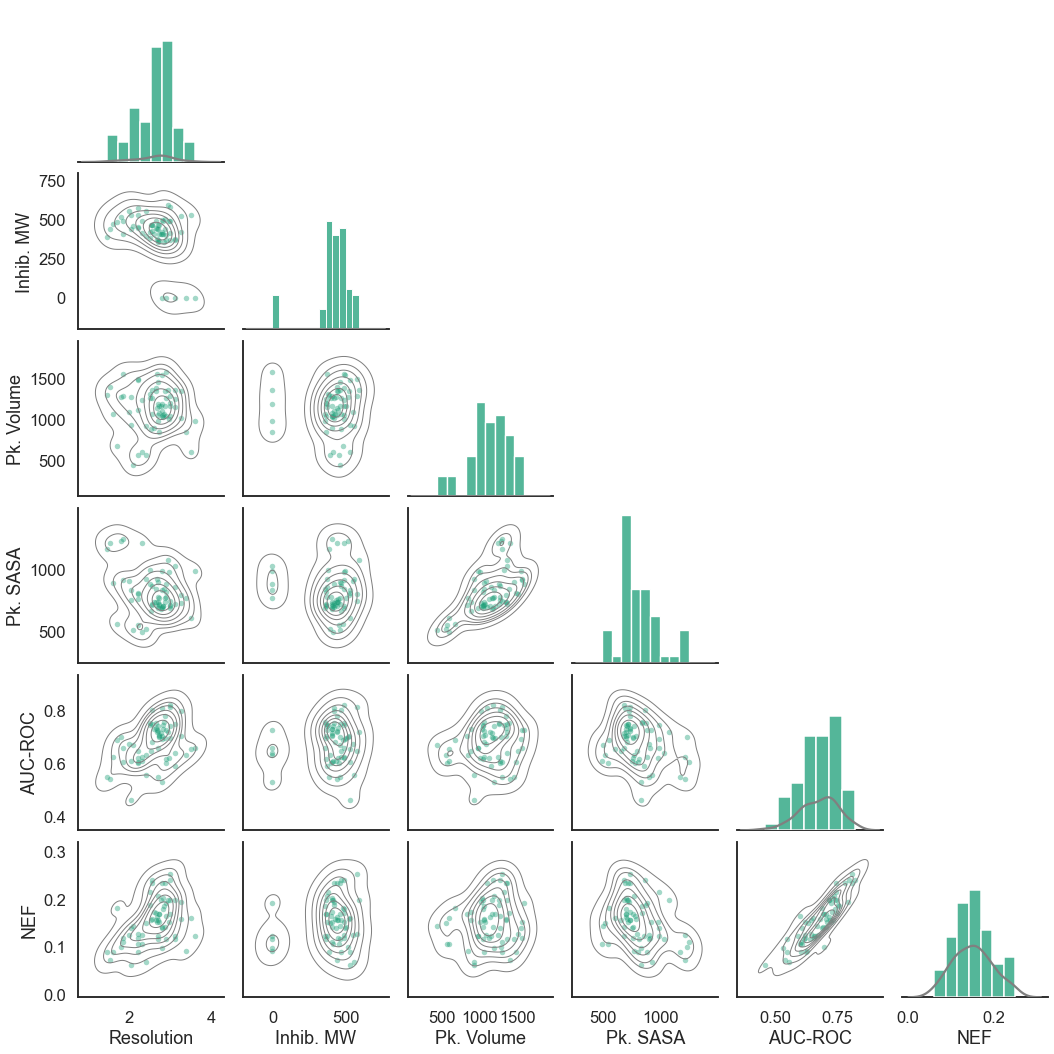

In [19]:
g = sns.pairplot(df_final, 
                 diag_kind = "hist", 
                 corner    = True,  
                 plot_kws = {'alpha': 0.4, 
                             's': 30, 
                             'edgecolor': 'k', 
                             'linewidth': 0})
g.map_lower(sns.kdeplot, levels = 8, 
            color = ".5", linewidths = 1)
g.map_diag(sns.kdeplot, color = '.5')
g.map_lower(corrfunc)
plt.show()

Finished!